# CID distribution over the hash space

This script allows to visualize how homogeneous is the CID distribution in the SHA256 Hash space.

The distributions are calculated using the Normalized SHA256 Hash space, which means that instead of having the values from [0, (2^256)-1], values go from [0, 1].

In [1]:
import sqlalchemy as sa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
import datetime

## Dependencies to manipulate CIDs
import multihash as mh
from cid import make_cid

## Dependencies to manipulate Control Variables
import os
from dotenv import dotenv_values

ENV_FILE='.env' # <- CHANGE THIS TO PLOT YOUR CONFIGURATION

dotenv_path = os.path.join('.env')
config = dotenv_values(dotenv_path)

# Control Values
DB_HOST=config['DB_HOST']
DB_PORT=config['DB_PORT']
DB_NAME=config['DB_NAME']
DB_USER=config['DB_USER']
DB_PASSWD=config['DB_PASSWD']
FIGS_FOLDER=config['FIGS_FOLDER']
## SQL queries related stuff
START_DATE=datetime.datetime.strptime(config['START_DATE'], '%Y-%m-%d')
FINISH_DATE=datetime.datetime.strptime(config['FINISH_DATE'], '%Y-%m-%d')
# Configure the main plotting configuration
## Plot related configurations
FIG_SIZE=(10,6)
sns.set_context("talk", font_scale=1)

## DB Credentials
print(
    f'connecting to database "{DB_NAME}" at "{DB_HOST}"\n',
    f'keeping plots at "{FIGS_FOLDER}"'
)

engine = sa.create_engine(
    f'postgresql://{DB_USER}:{DB_PASSWD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
con = engine.connect()

connecting to database "hoarder_prod" at "ec2-3-66-188-202.eu-central-1.compute.amazonaws.com"
 keeping plots at "./pics/"


In [2]:
## Obtain the whole list of CIDs and get their normalized distribution in the hash space
query = f"""
SELECT
    cid_hash
FROM cid_info
WHERE
    pub_time>='{START_DATE}' and pub_time<='{FINISH_DATE}'
"""

cids = pd.read_sql_query(sa.text(query), con)

# get multihash from the CID b58 string()
cids['multihash'] = cids.apply(lambda row: make_cid(row['cid_hash']).multihash ,axis=1)

# get the int of the multihash.hash()
cids['hash_int'] = cids.apply(lambda row: int.from_bytes( mh.decode(row['multihash']).digest, byteorder="big") ,axis=1)

sha256 = (2 ** 256) -1
# normalize multihash.hash() in int in sha256 space
cids['hash_int_norm'] = cids.apply(lambda row: row['hash_int'] / sha256 ,axis=1)

ordered_cids = cids.sort_values('hash_int_norm')

Text(0, 0.5, 'CIDs')

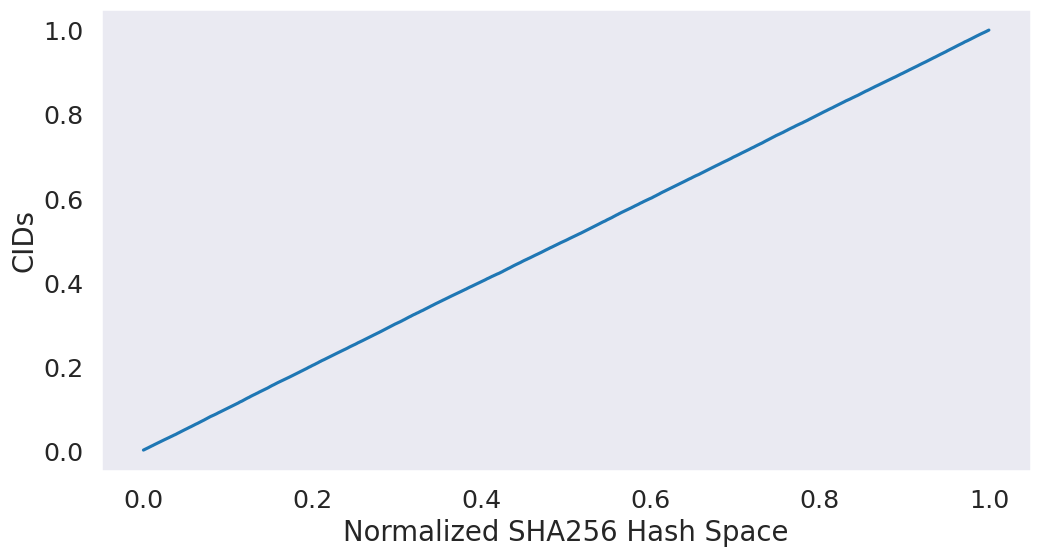

In [3]:
## plot the CDF distribution
 
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(12,6))

sns.lineplot(y=ordered_cids['hash_int_norm'], x=np.linspace(0, 1, len(ordered_cids['hash_int_norm'])))
plt.grid(axis='both')
plt.xlabel('Normalized SHA256 Hash Space')
plt.ylabel('CIDs')



490.58203125


(-0.05, 1.1)

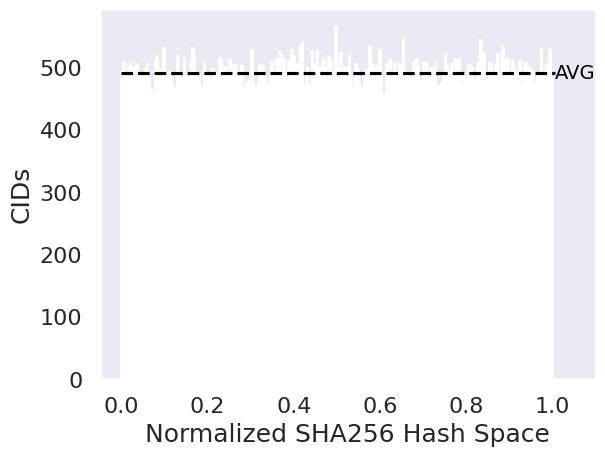

In [4]:
## plot the PFD distribution

BINS = 256 # KBUCKETs

bins = plt.hist(ordered_cids['hash_int_norm'], color='darkgrey', bins=BINS)

plt.grid()
plt.xlabel('Normalized SHA256 Hash Space', fontsize=18)
plt.ylabel('CIDs', fontsize=18)

mean = np.mean(bins[0])
maxi = max(bins[0])
mini = min(bins[0])

print(mean)

plt.hlines(y=[mean], xmin=0, xmax=1.005, color='black', linestyle='--', label='50%')
plt.text(1.006, mean+0.005, 'AVG', ha='left', va='center', color='black', fontsize=14)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.xlim(-0.05, 1.1)


In [5]:
## Close the connection with the DB 

engine.dispose()